In [1]:
import os
import pandas as pd
import networkx as nx
from infomap import Infomap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

lpa_dir=os.environ.get("LPA")


In [2]:
match_file = f"{lpa_dir}/ilash/ilash_ch6/output.match"

# Define the correct columns for iLASH output
cols = [
    "id1", "hap1", "id2", "hap2",
    "chr", "start", "end",
    "genomic_start", "genomic_end",
    "cm", "snp_count"
]

# Read with proper whitespace delimiter
df = pd.read_csv(match_file, delim_whitespace=True, names=cols)

# Initialize an undirected graph
G = nx.Graph()

# Add edges with weights (e.g., total shared cM)
for _, row in df.iterrows():
    u, v, cm = row["id1"], row["id2"], row["cm"]
    if G.has_edge(u, v):
        G[u][v]["weight"] += cm
    else:
        G.add_edge(u, v, weight=cm)


In [3]:
# Step 1: Relabel nodes with integers for Infomap
node_to_int = {node: idx for idx, node in enumerate(G.nodes())}
int_to_node = {idx: node for node, idx in node_to_int.items()}

# Step 2: Create new graph with integer node IDs
G_int = nx.relabel_nodes(G, node_to_int)

# Step 3: Run Infomap on the integer-labeled graph
im = Infomap()

for u, v, data in G_int.edges(data=True):
    im.add_link(u, v, float(data.get("weight", 1.0)))

im.run()

# Step 4: Extract community assignments and map back to original labels
communities = {int_to_node[node.node_id]: node.module_id for node in im.nodes}

# Step 5: Assign community attribute to original graph
nx.set_node_attributes(G, communities, "community")

# Optional: Check how many communities were detected
print(f"Number of communities detected: {len(set(communities.values()))}")


  Infomap v2.8.0 starts at 2025-06-11 14:20:15
  -> Input network: 
  -> No file output!
  OpenMP 201511 detected with 1 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 12238 nodes and 154737 links...
  -> One-level codelength: 12.2984941

Trial 1/1 starting at 2025-06-11 14:20:15
Two-level compression: 11% 1.7% 0.0323802136% 0.0373330018% 
Partitioned to codelength 3.71218645 + 7.01728413 = 10.72947058 in 926 (912 non-trivial) modules.
Super-level compression: 2.40525113% to codelength 10.47139987 in 81 top modules.

Recursive sub-structure compression: 7.95749484% 0.0075289499% 0% . Found 4 levels with codelength 10.43548255

=> Trial 1/1 finished in 2.42516017s with codelength 10.4354826


Summary after 1 trial
Best end modular solution in 4 levels:
Per level number of modules: 

/nas/longleaf/home/catererz/.conda/envs/lpa/lib/python3.9/site-packages/numpy/linalg/linalg.py:2546: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/nas/longleaf/home/catererz/.conda/envs/lpa/lib/python3.9/site-packages/numpy/linalg/linalg.py:2547: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
/nas/longleaf/home/catererz/.conda/envs/lpa/lib/python3.9/site-packages/numpy/linalg/linalg.py:2546: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/nas/longleaf/home/catererz/.conda/envs/lpa/lib/python3.9/site-packages/numpy/linalg/linalg.py:2547: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
/nas/longleaf/home/catererz/.conda/envs/lpa/lib/python3.9/site-packages/numpy/linalg/linalg.py:2546: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/nas/longleaf/home/catererz/.conda/envs/lpa/lib/python3.9/

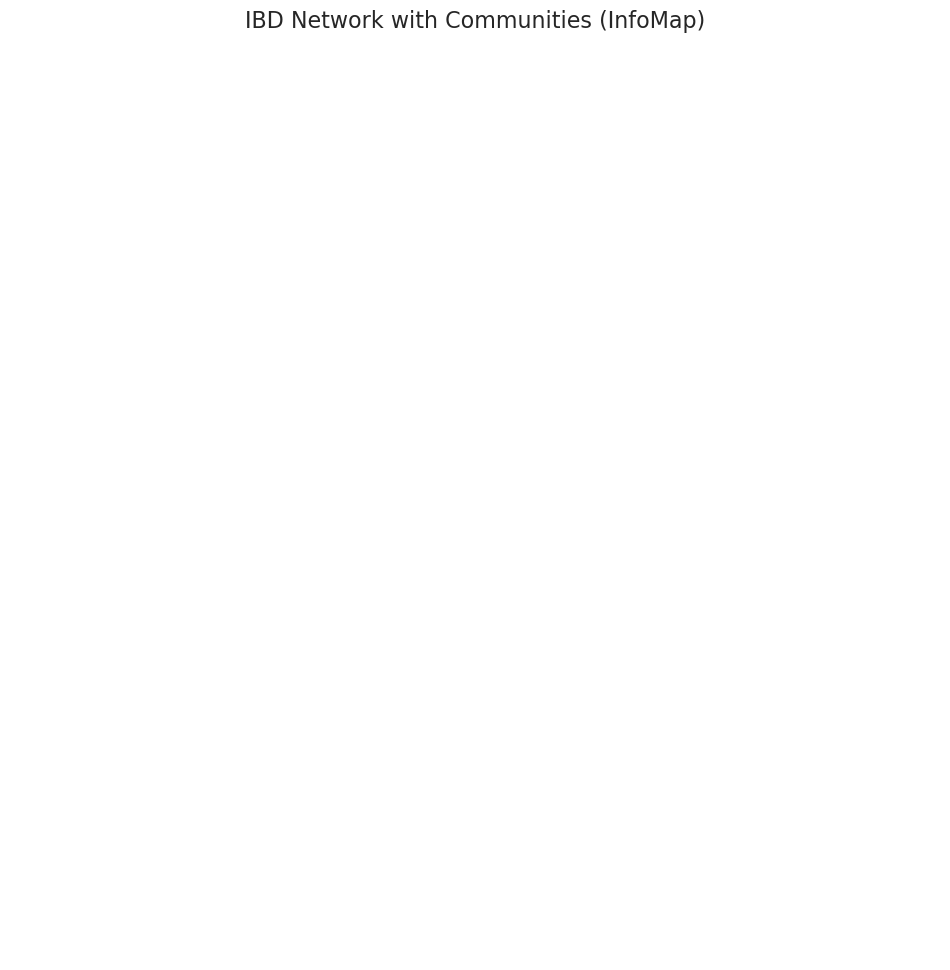

In [9]:
# Get communities and layout
colors = [G.nodes[n].get("community", 0) for n in G.nodes()]

# pos = nx.spring_layout(G, seed=42)
# pos = nx.kamada_kawai_layout(G, weight='weight')
# pos = nx.forceatlas2_layout(G, weight='weight')
pos = nx.arf_layout(G)
# pos = nx.spectral_layout(G, weight='weight')
# pos = nx.circular_layout(G)
# pos = nx.random_layout(G, seed=42)

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=colors, cmap="tab20")
plt.title("IBD Network with Communities (InfoMap)", fontsize=16)
plt.axis("off")
plt.show()